In [1]:
from jax.config import config; config.update("jax_enable_x64", True)
import jax
import jax.numpy as np
from jax import jit, vmap, random

import numpyro
from numpyro import handlers,sample
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from tqdm import tqdm
import time

import matplotlib.pyplot as plt

In [6]:
def nonlin(X):
    # the non-linearity we use in our neural network
    return np.tanh(X)

def model(X, Y, D_H):
    # a two-layer bayesian neural network with computational flow
    # given by D_X => D_H => D_H => D_Y where D_H is the number of
    # hidden units. (note we indicate tensor dimensions in the comments)
    D_X, D_Y = X.shape[1], 1

    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample("w1", dist.Normal(np.zeros((D_X, D_H)), np.ones((D_X, D_H))))  # D_X D_H
    z1 = nonlin(np.matmul(X, w1))   # N D_H  <= first layer of activations

    # sample second layer
    w2 = numpyro.sample("w2", dist.Normal(np.zeros((D_H, D_H)), np.ones((D_H, D_H))))  # D_H D_H
    z2 = nonlin(np.matmul(z1, w2))  # N D_H  <= second layer of activations

    # sample final layer of weights and neural network output
    w3 = numpyro.sample("w3", dist.Normal(np.zeros((D_H, D_Y)), np.ones((D_H, D_Y))))  # D_H D_Y
    z3 = np.matmul(z2, w3)  # N D_Y  <= output of the neural network

    # we put a prior on the observation noise
    prec_obs = numpyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / np.sqrt(prec_obs)

    # observe data
    numpyro.sample("Y", dist.Normal(z3, sigma_obs), obs=Y)

# helper function for HMC inference
def run_inference(model, rng_key, X, Y, D_H):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=500, num_chains=1)
    mcmc.run(rng_key, X, Y, D_H)
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()

# helper function for prediction
def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace['Y']['value']

In [7]:
def get_data(N=50, D_X=3, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    X = np.linspace(-1, 1, N)
    X = np.power(X[:, np.newaxis], np.arange(D_X))
    W = 0.5 * random.normal(key=random.PRNGKey(0),shape=(D_X,))
    Y = np.dot(X, W) + 0.5 * np.power(0.5 + X[:, 1], 2.0) * np.sin(4.0 * X[:, 1])
    Y += sigma_obs * random.normal(key=random.PRNGKey(0),shape=(N,))
    Y = Y[:, np.newaxis]
    Y -= np.mean(Y)
    Y /= np.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = np.linspace(-1.3, 1.3, N_test)
    X_test = np.power(X_test[:, np.newaxis], np.arange(D_X))

    return X, Y, X_test

In [8]:
X,Y,X_test=get_data(N_test=50)

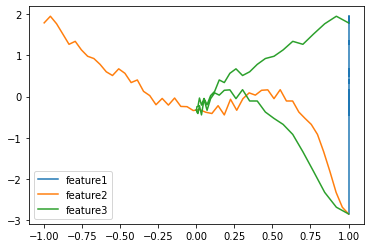

In [9]:
plt.plot(X[:,0],Y,label='feature1')
plt.plot(X[:,1],Y,label='feature2')
plt.plot(X[:,2],Y,label='feature3')
plt.legend()

In [16]:
N=50
D_X, D_H = 3,3
X, Y, X_test = get_data(N=N, D_X=D_X,N_test=100)
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, rng_key, X, Y, D_H)

sample: 100%|██████████| 1500/1500 [00:12<00:00, 115.51it/s, 511 steps of size 6.25e-03. acc. prob=0.94] 



MCMC elapsed time: 14.259047031402588


In [17]:
model_learned = handlers.substitute(handlers.seed(model, random.PRNGKey(0)), samples)
# note that Y will be sampled in the model because we pass Y=None here
model_trace = handlers.trace(model_learned).get_trace(X=X_test, Y=None, D_H=D_H)

In [18]:
pred = model_trace['Y']['value']

In [25]:
pred.shape

(500, 100, 500)

In [27]:
mean_prediction = np.mean(pred[:,:,0], axis=0)
percentiles = np.percentile(pred[:,:,0], [5.0, 95.0], axis=0)

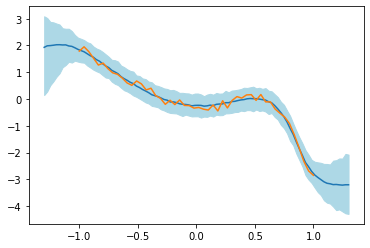

In [32]:
plt.plot(X_test[:,1],mean_prediction)
plt.fill_between(X_test[:, 1], percentiles[0, :], percentiles[1, :], color='lightblue')
plt.plot(X[:,1],Y)

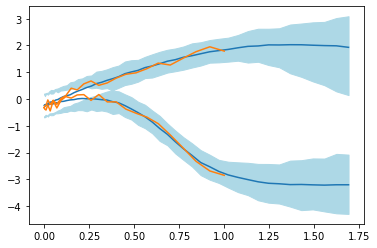

In [33]:
plt.plot(X_test[:,2],mean_prediction)
plt.fill_between(X_test[:, 2], percentiles[0, :], percentiles[1, :], color='lightblue')
plt.plot(X[:,2],Y)